# Phase A - Data Validation
In this notebook we validate that GAG patterns are detectable in the human data. To do this we will:

- load the current scVI embeddings from data/interim/human_brain_atlas_processed_scvi_large.h5ad which contain human brain atlas cells. the representations should be found in adata.obsm['X_scvi_large']

- We will compute per-cell GAG enrichment scores

- Run ANOVA: enrichment ~ cluster for each gene set

- Plot UMAP colored by GAG enrichment cluster assignment

- We will hopefully see GAG-high vs GAG-low clusters. 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scanpy as sc
import scvi
import torch


/opt/homebrew/Caskroom/miniforge/base/envs/rl_env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Load Data

In [2]:
raw_data_path = './interim/human_brain_atlas_processed_scvi_large.h5ad'

adata = sc.read_h5ad(raw_data_path)
print(f"Loaded data with shape: {adata.shape}")
print(f"Number of cells: {adata.n_obs}")
print(f"Number of genes: {adata.n_vars}")
print(f"Available metadata: {list(adata.obs.columns)}")

Loaded data with shape: (212245, 32165)
Number of cells: 212245
Number of genes: 32165
Available metadata: ['Class', 'Region', 'sex', 'development_stage', 'Batch_ID', 'Age', '_scvi_batch', '_scvi_labels', 'doublet', 'singlet', 'leiden']


## Convert Ensembl IDs to Gene Symbols

The dataset uses Ensembl IDs (e.g., ENSG00000000003) but we need gene symbols (e.g., TSPAN6) for the GAG gene sets.


In [3]:
# # Convert Ensembl IDs to gene symbols
# try:
#     import mygene
#     mg = mygene.MyGeneInfo()
    
#     print("Converting Ensembl IDs to gene symbols...")
#     print(f"Total genes: {len(adata.var_names)}")
    
#     # Save original Ensembl IDs
#     ensembl_ids = adata.var_names.tolist()
    
#     # Query in batches to avoid API limits
#     batch_size = 500
#     gene_info_list = []
    
#     for i in range(0, len(ensembl_ids), batch_size):
#         batch = ensembl_ids[i:i+batch_size]
#         print(f"Processing batch {i//batch_size + 1}/{(len(ensembl_ids)-1)//batch_size + 1}...")
#         try:
#             results = mg.querymany(batch, scopes='ensembl.gene', fields='symbol', species='human', as_dataframe=False)
#             gene_info_list.extend(results)
#         except Exception as e:
#             print(f"Warning: Error in batch {i//batch_size + 1}: {e}")
#             # Add None for failed queries
#             gene_info_list.extend([{'query': ens_id, 'symbol': None} for ens_id in batch])
    
#     # Create mapping dictionary
#     ensembl_to_symbol = {}
#     for item in gene_info_list:
#         ens_id = item.get('query', '')
#         symbol = item.get('symbol', None)
#         if symbol:
#             ensembl_to_symbol[ens_id] = symbol
#         else:
#             # If no symbol found, keep the Ensembl ID
#             ensembl_to_symbol[ens_id] = ens_id
    
#     # Update var_names with gene symbols
#     # Handle duplicates by appending _1, _2, etc.
#     new_var_names = []
#     symbol_counts = {}
#     for ens_id in ensembl_ids:
#         symbol = ensembl_to_symbol.get(ens_id, ens_id)
#         if symbol in symbol_counts:
#             symbol_counts[symbol] += 1
#             new_symbol = f"{symbol}_{symbol_counts[symbol]}"
#         else:
#             symbol_counts[symbol] = 0
#             new_symbol = symbol
#         new_var_names.append(new_symbol)
    
#     # Store both Ensembl IDs and gene symbols
#     adata.var['ensembl_id'] = ensembl_ids
#     adata.var['gene_symbol'] = new_var_names
    
#     # Update var_names to use gene symbols
#     adata.var_names = new_var_names
    
#     print(f"\nConversion complete!")
#     print(f"Unique gene symbols: {len(set(new_var_names))}")
#     print(f"Example mappings:")
#     for i in range(min(5, len(ensembl_ids))):
#         print(f"  {ensembl_ids[i]} -> {new_var_names[i]}")
        
# except ImportError:
#     print("mygene package not found. Installing...")
#     import subprocess
#     import sys
#     subprocess.check_call([sys.executable, "-m", "pip", "install", "mygene"])
#     print("Please restart the kernel and run this cell again.")
# except Exception as e:
#     print(f"Error during conversion: {e}")
#     print("Falling back to alternative method...")
    
    # Alternative: Use pybiomart
try:
    from pybiomart import Dataset
    print("Using pybiomart for conversion...")
    dataset = Dataset(name='hsapiens_gene_ensembl', host='http://www.ensembl.org')
    mapping = dataset.query(attributes=['ensembl_gene_id', 'external_gene_name'])
    mapping_dict = dict(zip(mapping['Gene stable ID'], mapping['Gene name']))
    
    # Save original Ensembl IDs
    ensembl_ids = adata.var_names.tolist()
    
    # Update var_names
    new_var_names = [mapping_dict.get(ens_id, ens_id) for ens_id in ensembl_ids]
    
    # Store both
    adata.var['ensembl_id'] = ensembl_ids
    adata.var['gene_symbol'] = new_var_names
    adata.var_names = new_var_names
    
    print("Conversion complete using pybiomart!")
    print(f"Example mappings:")
    for i in range(min(5, len(ensembl_ids))):
        print(f"  {ensembl_ids[i]} -> {new_var_names[i]}")
except ImportError:
    print("Neither mygene nor pybiomart available.")
    print("Please install one of them: pip install mygene")
    print("Or manually create a mapping file.")


Using pybiomart for conversion...
Conversion complete using pybiomart!
Example mappings:
  ENSG00000000003 -> TSPAN6
  ENSG00000000005 -> TNMD
  ENSG00000000419 -> DPM1
  ENSG00000000457 -> SCYL3
  ENSG00000000460 -> FIRRM


In [4]:
adata

AnnData object with n_obs × n_vars = 212245 × 32165
    obs: 'Class', 'Region', 'sex', 'development_stage', 'Batch_ID', 'Age', '_scvi_batch', '_scvi_labels', 'doublet', 'singlet', 'leiden'
    var: 'ensembl_id', 'gene_symbol'
    uns: '_scvi_manager_uuid', '_scvi_uuid', 'leiden', 'leiden_colors', 'leiden_sizes', 'neighbors', 'paga', 'umap'
    obsm: 'X_scvi_large', 'X_umap', 'scVI'
    obsp: 'connectivities', 'distances'

<Axes: xlabel='Class'>

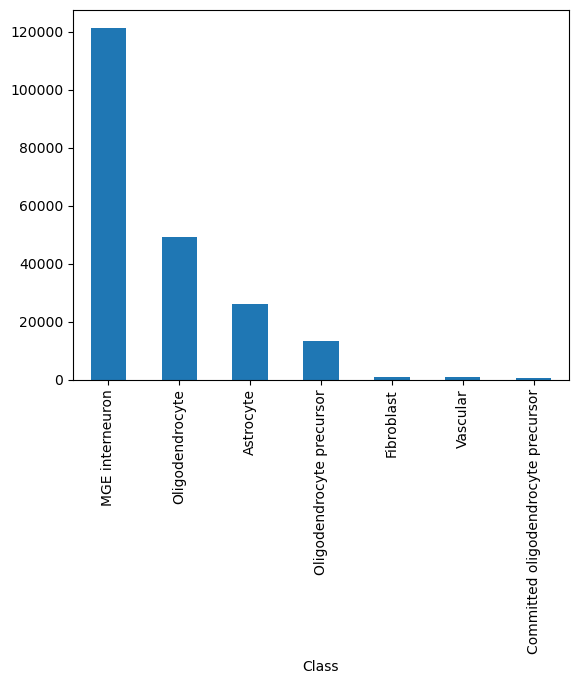

In [5]:
adata.obs['Class'].value_counts().plot(kind='bar')

In [6]:
# shape of the scVI representations
adata.obsm['X_scvi_large'].shape

(212245, 40)

In [7]:
adata.var_names

Index([   'TSPAN6',      'TNMD',      'DPM1',     'SCYL3',     'FIRRM',
             'FGR',       'CFH',     'FUCA2',      'GCLC',      'NFYA',
       ...
               nan,         nan,         nan, 'LINC02498',         nan,
               nan,         nan,   'MGC4859',         nan,         nan],
      dtype='object', length=32165)

## Define GAG Gene Sets

Based on the project proposal, we define 6 GAG-related gene sets:
1. CS biosynthesis
2. CS sulfation
3. HS biosynthesis
4. HS sulfation
5. Sulfate activation
6. PNN core


In [8]:
# Define GAG gene sets based on project proposal
gag_gene_sets = {
    'CS_biosynthesis': ['CSGALNACT1', 'CSGALNACT2', 'CHSY1', 'CHSY3', 'CHPF', 'CHPF2'],
    'CS_sulfation': ['CHST11', 'CHST12', 'CHST13', 'CHST14', 'CHST15'],
    'HS_biosynthesis': ['EXT1', 'EXT2', 'EXTL1', 'EXTL2', 'EXTL3'],
    'HS_sulfation': ['NDST1', 'NDST2', 'HS2ST1', 'HS6ST1', 'HS6ST2', 'HS6ST3', 'HS3ST1', 'HS3ST2'],
    'Sulfate_activation': ['PAPSS1', 'PAPSS2', 'SLC35B2', 'SLC35B3'],
    'PNN_core': ['ACAN', 'BCAN', 'NCAN', 'VCAN', 'HAPLN1', 'HAPLN2', 'HAPLN4', 'TNC', 'TNR']
}

# Check which genes are present in the dataset
print("Checking gene availability in dataset...")
all_genes = adata.var_names.tolist()
gene_set_availability = {}

for set_name, genes in gag_gene_sets.items():
    available = [g for g in genes if g in all_genes]
    missing = [g for g in genes if g not in all_genes]
    gene_set_availability[set_name] = {
        'available': available,
        'missing': missing,
        'coverage': len(available) / len(genes) if len(genes) > 0 else 0
    }
    print(f"\n{set_name}:")
    print(f"  Available: {len(available)}/{len(genes)} ({gene_set_availability[set_name]['coverage']:.1%})")
    if missing:
        print(f"  Missing: {missing}")

# Store only available genes for each set
gag_gene_sets_available = {
    name: info['available'] 
    for name, info in gene_set_availability.items() 
    if len(info['available']) > 0
}
print(f"\nTotal gene sets with available genes: {len(gag_gene_sets_available)}")


Checking gene availability in dataset...

CS_biosynthesis:
  Available: 6/6 (100.0%)

CS_sulfation:
  Available: 5/5 (100.0%)

HS_biosynthesis:
  Available: 5/5 (100.0%)

HS_sulfation:
  Available: 8/8 (100.0%)

Sulfate_activation:
  Available: 4/4 (100.0%)

PNN_core:
  Available: 9/9 (100.0%)

Total gene sets with available genes: 6


## Compute Per-Cell GAG Enrichment Scores

We'll compute enrichment scores for each gene set using mean expression of genes in the set.


In [9]:
from scipy import stats
from scipy.stats import f_oneway
import warnings
warnings.filterwarnings('ignore')

# Ensure we're working with log-normalized data
# If not already normalized, we'll use raw counts normalized by mean
if 'log1p' not in adata.layers and 'X' in adata.layers:
    # Use raw counts if available
    expr_matrix = adata.layers['X'].toarray() if hasattr(adata.layers['X'], 'toarray') else adata.layers['X']
else:
    # Use main expression matrix
    expr_matrix = adata.X.toarray() if hasattr(adata.X, 'toarray') else adata.X

# Compute enrichment scores as mean expression of genes in each set
print("Computing GAG enrichment scores...")
gag_enrichment_scores = {}

for set_name, genes in gag_gene_sets_available.items():
    # Find indices of genes in the dataset
    gene_indices = [adata.var_names.get_loc(g) for g in genes if g in adata.var_names]
    
    if len(gene_indices) == 0:
        print(f"Warning: No genes found for {set_name}")
        continue
    
    # Compute mean expression across genes in the set for each cell
    # Take mean of log-normalized expression (or log1p transform if needed)
    if expr_matrix.max() > 20:  # Likely raw counts, apply log1p
        set_expr = np.log1p(expr_matrix[:, gene_indices])
    else:
        set_expr = expr_matrix[:, gene_indices]
    
    enrichment = np.mean(set_expr, axis=1)
    gag_enrichment_scores[set_name] = enrichment
    
    # Store in adata.obs for easy access
    adata.obs[f'GAG_{set_name}'] = enrichment
    
    print(f"{set_name}: mean={enrichment.mean():.3f}, std={enrichment.std():.3f}")

# Compute overall GAG enrichment (mean across all sets)
overall_gag = np.mean([scores for scores in gag_enrichment_scores.values()], axis=0)
adata.obs['GAG_overall'] = overall_gag
print(f"\nOverall GAG enrichment: mean={overall_gag.mean():.3f}, std={overall_gag.std():.3f}")


Computing GAG enrichment scores...
CS_biosynthesis: mean=0.289, std=0.259
CS_sulfation: mean=0.141, std=0.176
HS_biosynthesis: mean=0.349, std=0.313
HS_sulfation: mean=0.277, std=0.298
Sulfate_activation: mean=0.174, std=0.193
PNN_core: mean=0.185, std=0.213

Overall GAG enrichment: mean=0.236, std=0.174


## Run ANOVA: enrichment ~ cluster

For each gene set, we'll test whether enrichment scores differ significantly across clusters using one-way ANOVA.


In [10]:
# Ensure we have cluster assignments
# Use 'leiden' if available, otherwise create a simple clustering
if 'leiden' not in adata.obs.columns:
    print("Computing Leiden clustering for ANOVA analysis...")
    sc.pp.neighbors(adata, use_rep='X_scvi_large', n_neighbors=15, n_pcs=40)
    sc.tl.leiden(adata, resolution=0.5, key_added='leiden')

clusters = adata.obs['leiden'].astype(str)
unique_clusters = sorted(clusters.unique())
print(f"Number of clusters: {len(unique_clusters)}")
print(f"Cluster sizes: {clusters.value_counts().head(10)}")

# Run ANOVA for each gene set
anova_results = {}

print("\n" + "="*60)
print("ANOVA Results: enrichment ~ cluster")
print("="*60)

for set_name, enrichment in gag_enrichment_scores.items():
    # Group enrichment scores by cluster
    cluster_groups = [enrichment[clusters == c] for c in unique_clusters]
    
    # Run one-way ANOVA
    f_stat, p_value = f_oneway(*cluster_groups)
    
    anova_results[set_name] = {
        'F_statistic': f_stat,
        'p_value': p_value,
        'mean_by_cluster': {c: enrichment[clusters == c].mean() for c in unique_clusters}
    }
    
    # Print results
    significance = "***" if p_value < 0.001 else "**" if p_value < 0.01 else "*" if p_value < 0.05 else ""
    print(f"\n{set_name}:")
    print(f"  F-statistic: {f_stat:.3f}")
    print(f"  p-value: {p_value:.2e} {significance}")
    print(f"  Mean enrichment range: [{min(anova_results[set_name]['mean_by_cluster'].values()):.3f}, "
          f"{max(anova_results[set_name]['mean_by_cluster'].values()):.3f}]")

# Overall GAG ANOVA
cluster_groups_overall = [overall_gag[clusters == c] for c in unique_clusters]
f_stat_overall, p_value_overall = f_oneway(*cluster_groups_overall)
anova_results['GAG_overall'] = {
    'F_statistic': f_stat_overall,
    'p_value': p_value_overall,
    'mean_by_cluster': {c: overall_gag[clusters == c].mean() for c in unique_clusters}
}

print(f"\n{'GAG_overall':}")
print(f"  F-statistic: {f_stat_overall:.3f}")
print(f"  p-value: {p_value_overall:.2e}")
print(f"  Mean enrichment range: [{min(anova_results['GAG_overall']['mean_by_cluster'].values()):.3f}, "
      f"{max(anova_results['GAG_overall']['mean_by_cluster'].values()):.3f}]")
print("="*60)


Number of clusters: 349
Cluster sizes: leiden
0     67343
2     53984
4     49213
5     26005
6     13590
9      1711
10       33
1         3
12        3
14        3
Name: count, dtype: int64

ANOVA Results: enrichment ~ cluster

CS_biosynthesis:
  F-statistic: 277.013
  p-value: 0.00e+00 ***
  Mean enrichment range: [0.000, 1.514]

CS_sulfation:
  F-statistic: 269.999
  p-value: 0.00e+00 ***
  Mean enrichment range: [0.000, 0.936]

HS_biosynthesis:
  F-statistic: 392.115
  p-value: 0.00e+00 ***
  Mean enrichment range: [0.000, 1.502]

HS_sulfation:
  F-statistic: 613.468
  p-value: 0.00e+00 ***
  Mean enrichment range: [0.000, 1.398]

Sulfate_activation:
  F-statistic: 53.108
  p-value: 0.00e+00 ***
  Mean enrichment range: [0.000, 0.795]

PNN_core:
  F-statistic: 724.326
  p-value: 0.00e+00 ***
  Mean enrichment range: [0.000, 1.330]

GAG_overall
  F-statistic: 492.323
  p-value: 0.00e+00
  Mean enrichment range: [0.000, 0.854]


### The F-stats tells us:
 "Are the cluster means different from each other, compared to the noise within clusters?". we want F stat to be large, ie: The differences between clusters are F-stat times larger than the variation within clusters. You can interpret this as; "If I randomly pick two cells from different clusters, their PNN expression is likely to be very different. If I pick two cells from the same cluster, their PNN expression is likely to be very similar"

If F = 2-3 (borderline):

Between-cluster differences barely exceed within-cluster noise
Clusters aren't meaningfully separated by this gene set

F < 1:

No separation at all - clusters are random with respect to this gene set

HOWEVER,
This doesn't necessarily mean the clustering is good. It just means it's consistent with GAG patterns. The large number of clusters could be:

1) Biologically meaningful subtypes with distinct GAG programs, OR
2) Overfragmentation where even small noise differences are creating separate clusters

The singleton clusters (n=1 cells) suggest #2 is happening, which is fine, because this is what we aim to solve with RL clustering

## Visualize Results

We'll create UMAP plots colored by GAG enrichment scores and cluster assignments.


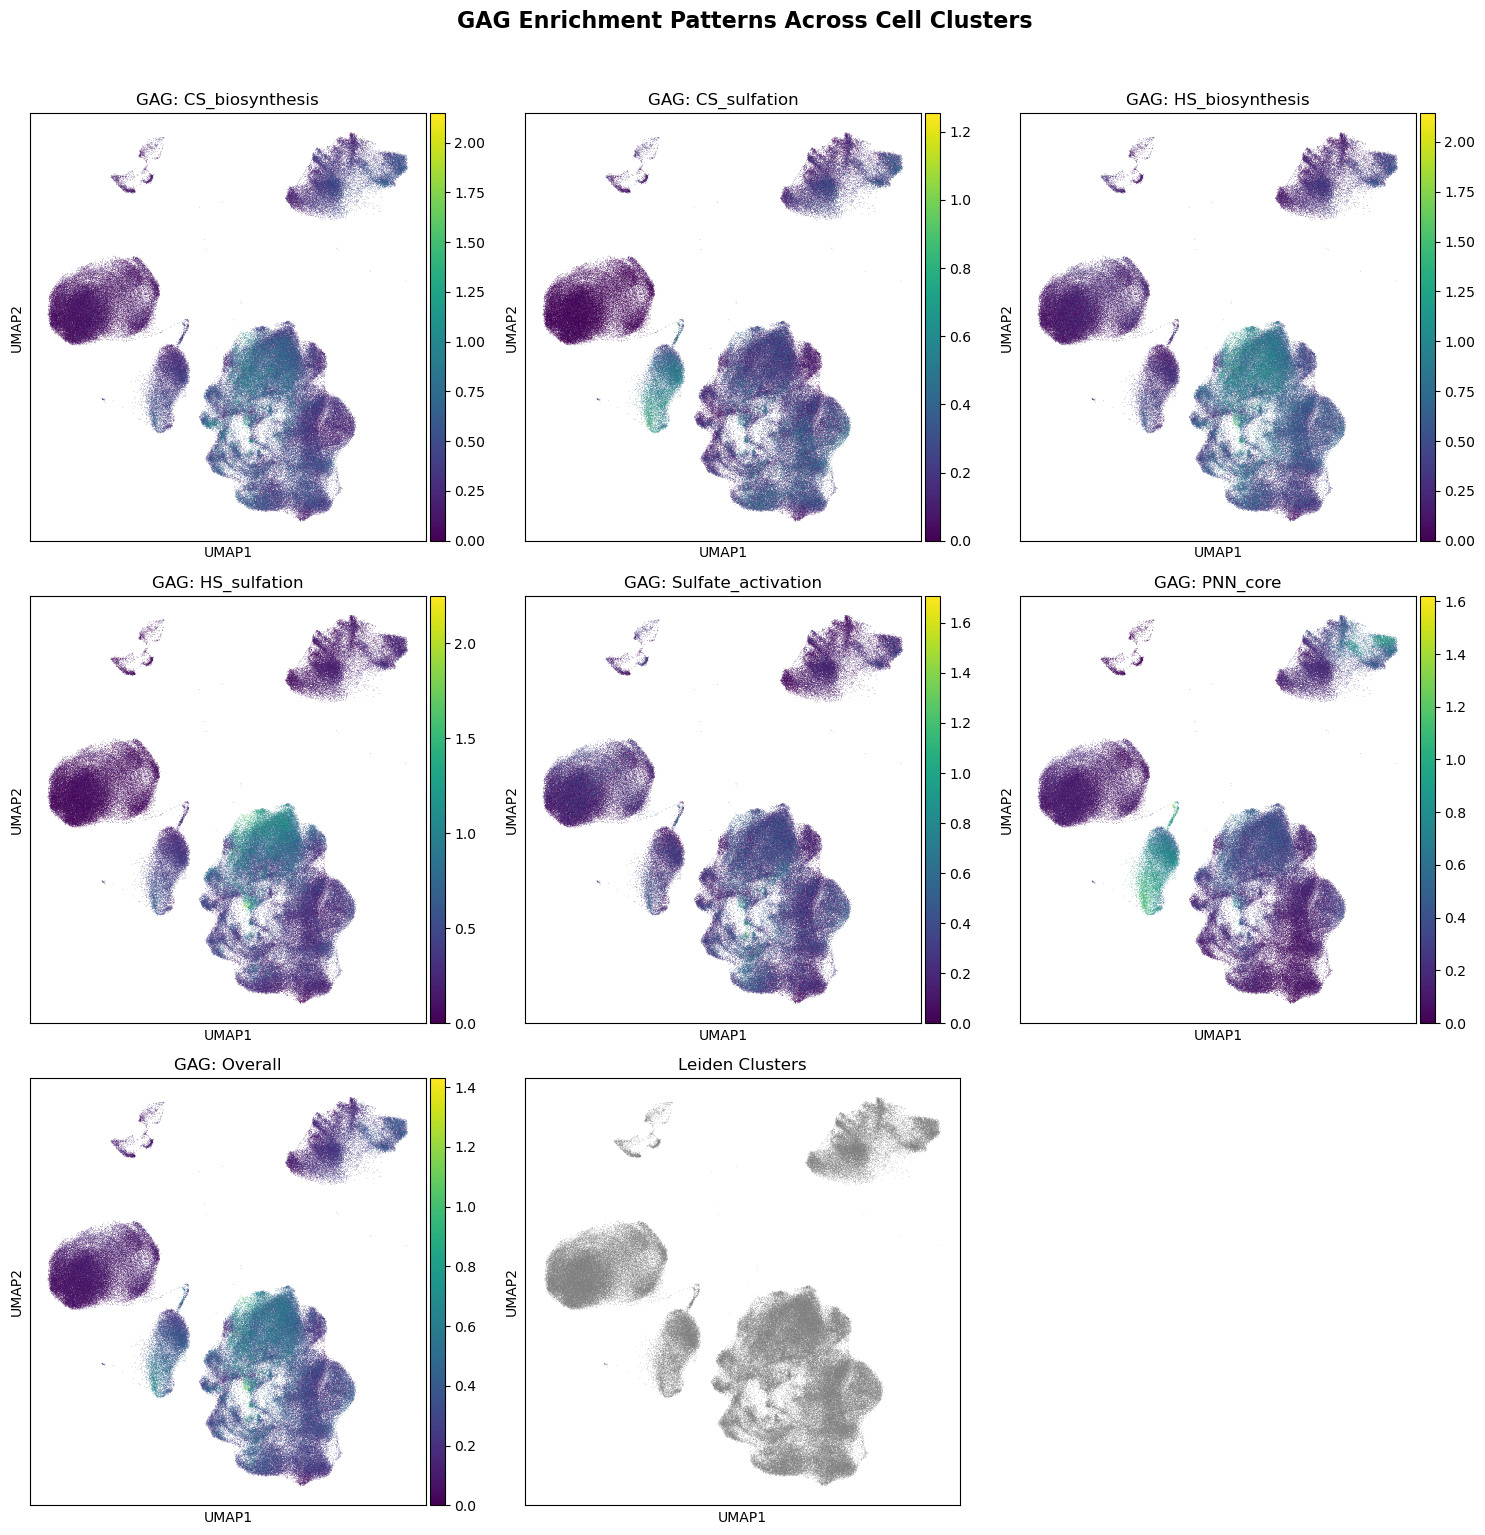

In [11]:
# Compute UMAP if not already present
if 'X_umap' not in adata.obsm:
    print("Computing UMAP...")
    sc.pp.neighbors(adata, use_rep='X_scvi_large', n_neighbors=15, n_pcs=40)
    sc.tl.umap(adata)

# Create comprehensive visualization
n_sets = len(gag_gene_sets_available) + 2  # +2 for overall and cluster
n_cols = 3
n_rows = (n_sets + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5*n_rows))
axes = axes.flatten() if n_rows > 1 else [axes] if n_cols == 1 else axes

# Add figure title
fig.suptitle('GAG Enrichment Patterns Across Cell Clusters', fontsize=16, fontweight='bold', y=1.02)

# Plot each gene set
plot_idx = 0
for set_name in gag_gene_sets_available.keys():
    sc.pl.umap(adata, color=f'GAG_{set_name}', ax=axes[plot_idx], 
                show=False, title=f'GAG: {set_name}', cmap='viridis', legend_loc=None)
    plot_idx += 1

# Plot overall GAG
sc.pl.umap(adata, color='GAG_overall', ax=axes[plot_idx], 
           show=False, title='GAG: Overall', cmap='viridis', legend_loc=None)
plot_idx += 1

# Plot clusters
sc.pl.umap(adata, color='leiden', ax=axes[plot_idx], 
           show=False, title='Leiden Clusters', legend_loc=None)
plot_idx += 1

# Hide unused subplots
for idx in range(plot_idx, len(axes)):
    axes[idx].axis('off')

plt.tight_layout()
plt.show()


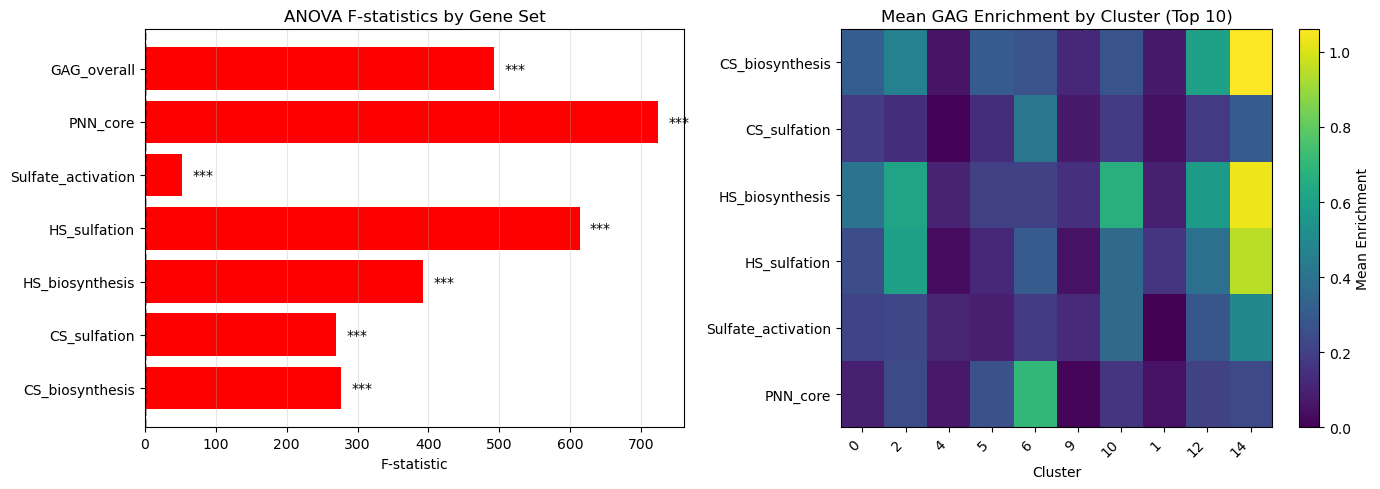

In [12]:
# Create a summary plot showing ANOVA results
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: F-statistics for each gene set
set_names = list(gag_gene_sets_available.keys()) + ['GAG_overall']
f_stats = [anova_results[name]['F_statistic'] for name in set_names]
p_values = [anova_results[name]['p_value'] for name in set_names]

colors = ['red' if p < 0.05 else 'gray' for p in p_values]
axes[0].barh(set_names, f_stats, color=colors)
axes[0].set_xlabel('F-statistic')
axes[0].set_title('ANOVA F-statistics by Gene Set')
axes[0].axvline(x=1, color='black', linestyle='--', alpha=0.3)
axes[0].grid(axis='x', alpha=0.3)

# Add p-value annotations
for i, (name, p_val) in enumerate(zip(set_names, p_values)):
    sig = "***" if p_val < 0.001 else "**" if p_val < 0.01 else "*" if p_val < 0.05 else "ns"
    axes[0].text(f_stats[i] + max(f_stats)*0.02, i, sig, va='center', fontsize=10)

# Plot 2: Heatmap of mean enrichment by cluster (top clusters)
top_clusters = clusters.value_counts().head(10).index.tolist()
heatmap_data = []
for set_name in gag_gene_sets_available.keys():
    row = [anova_results[set_name]['mean_by_cluster'].get(c, 0) for c in top_clusters]
    heatmap_data.append(row)

heatmap_data = np.array(heatmap_data)
im = axes[1].imshow(heatmap_data, aspect='auto', cmap='viridis', interpolation='nearest')
axes[1].set_yticks(range(len(gag_gene_sets_available)))
axes[1].set_yticklabels(list(gag_gene_sets_available.keys()))
axes[1].set_xticks(range(len(top_clusters)))
axes[1].set_xticklabels(top_clusters, rotation=45, ha='right')
axes[1].set_xlabel('Cluster')
axes[1].set_title('Mean GAG Enrichment by Cluster (Top 10)')
plt.colorbar(im, ax=axes[1], label='Mean Enrichment')

plt.tight_layout()
plt.show()


## Compare Cluster Quality: All Cells vs Interneurons Only

We compare GAG signal strength when clustering all cells versus focusing on interneurons only, since interneurons are the primary cell type of interest for PNN/GAG studies.


In [18]:
# Helper function to compute GAG F-statistics
def compute_GAG_F_stats(adata_subset, cluster_labels):
    """
    Compute mean F-statistic across all GAG gene sets for given cluster assignments.
    
    Parameters:
    -----------
    adata_subset : AnnData
        Subset of data to analyze
    cluster_labels : pd.Series or array
        Cluster assignments for each cell
        
    Returns:
    --------
    float : Mean F-statistic across all GAG gene sets
    """
    f_stats = []
    unique_clusters = sorted(cluster_labels.unique())
    
    for set_name in gag_gene_sets_available.keys():
        if f'GAG_{set_name}' not in adata_subset.obs.columns:
            continue
            
        enrichment = adata_subset.obs[f'GAG_{set_name}'].values
        cluster_groups = [enrichment[cluster_labels == c] for c in unique_clusters]
        
        # Run one-way ANOVA
        if len(unique_clusters) > 1 and all(len(g) > 0 for g in cluster_groups):
            f_stat, _ = f_oneway(*cluster_groups)
            f_stats.append(f_stat)
    
    return np.mean(f_stats) if f_stats else 0.0

# Quick experiment: Compare F-stats on filtered vs. unfiltered
print("="*60)
print("Comparing Cluster Quality: All Cells vs Interneurons Only")
print("="*60)

# Scenario A: All cells (using existing leiden clustering)
print("\nScenario A: All cells")
if 'leiden' in adata.obs.columns:
    F_all = compute_GAG_F_stats(adata, adata.obs['leiden'])
    n_clusters_all = adata.obs['leiden'].nunique()
    n_cells_all = adata.n_obs
    print(f"  Number of cells: {n_cells_all:,}")
    print(f"  Number of clusters: {n_clusters_all}")
    print(f"  Mean F-statistic: {F_all:.3f}")
else:
    print("  Computing Leiden clustering for all cells...")
    sc.pp.neighbors(adata, use_rep='X_scvi_large', n_neighbors=10, n_pcs=40)
    sc.tl.leiden(adata, resolution=0.5, key_added='leiden_all')
    F_all = compute_GAG_F_stats(adata, adata.obs['leiden_all'])
    n_clusters_all = adata.obs['leiden_all'].nunique()
    n_cells_all = adata.n_obs
    print(f"  Number of cells: {n_cells_all:,}")
    print(f"  Number of clusters: {n_clusters_all}")
    print(f"  Mean F-statistic: {F_all:.3f}")

# Scenario B: Interneurons only
print("\nScenario B: Interneurons only")
# Check available interneuron types# Scenario B: Interneurons only (FAST VERSION)
print("\nScenario B: Interneurons only (using existing graph)")
interneuron_mask = adata.obs['Class'] == 'MGE interneuron'
interneurons = adata[interneuron_mask].copy()

if 'leiden' in interneurons.obs.columns:
    F_int = compute_GAG_F_stats(interneurons, interneurons.obs['leiden'])
    n_clusters_int = interneurons.obs['leiden'].nunique()
    n_cells_int = interneurons.n_obs
    print(f"  Number of cells: {n_cells_int:,}")
    print(f"  Number of clusters: {n_clusters_int}")
    print(f"  Mean F-statistic: {F_int:.3f}")
else:
    print("  Computing Leiden clustering for all cells...")
    sc.pp.neighbors(interneurons, use_rep='X_scvi_large', n_neighbors=10, n_pcs=40)
    sc.tl.leiden(interneurons, resolution=0.5, key_added='leiden_all')
    F_int = compute_GAG_F_stats(interneurons, interneurons.obs['leiden_all'])
    n_clusters_int = interneurons.obs['leiden_all'].nunique()
    n_cells_int = interneurons.n_obs
    print(f"  Number of cells: {n_cells_int:,}")
    print(f"  Number of clusters: {n_clusters_int}")
    print(f"  Mean F-statistic: {F_int:.3f}")


print("="*60)


Comparing Cluster Quality: All Cells vs Interneurons Only

Scenario A: All cells
  Number of cells: 212,245
  Number of clusters: 349
  Mean F-statistic: 388.338

Scenario B: Interneurons only

Scenario B: Interneurons only (using existing graph)
  Number of cells: 121,427
  Number of clusters: 64
  Mean F-statistic: 313.965


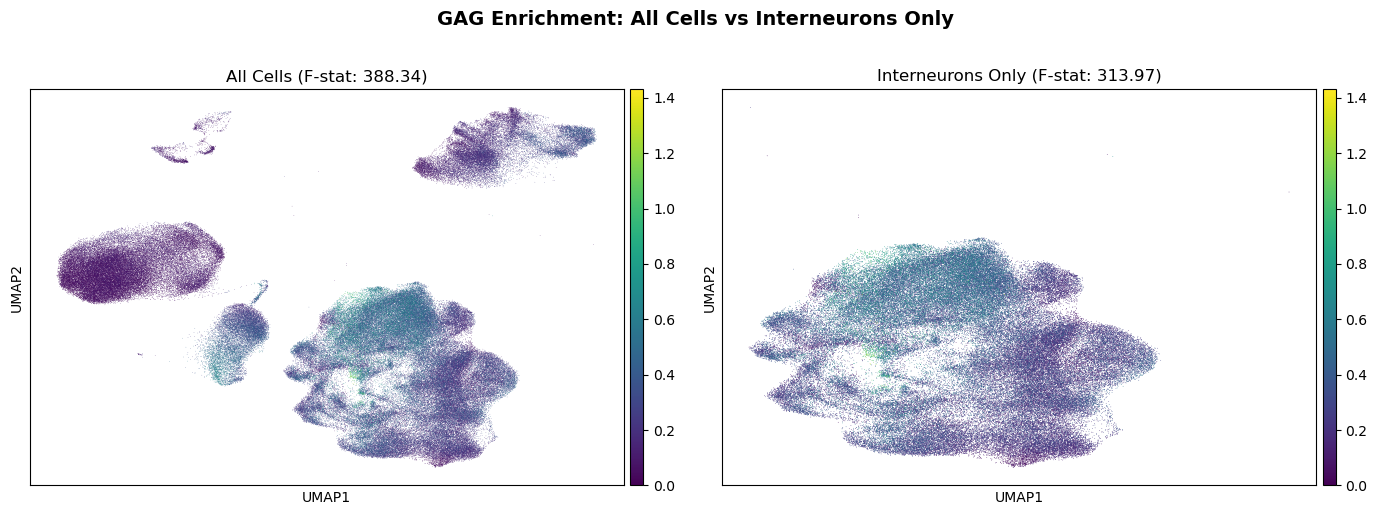

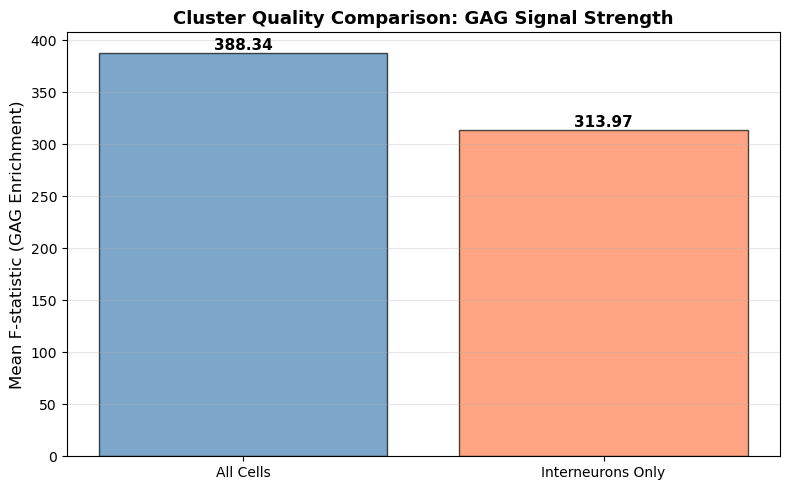

In [19]:
# Visualize the comparison if interneurons were found and successfully clustered
if interneurons is not None and F_int is not None:
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Plot 1: All cells UMAP colored by GAG overall
    sc.pl.umap(adata, color='GAG_overall', ax=axes[0], 
               show=False, title=f'All Cells (F-stat: {F_all:.2f})', 
               cmap='viridis', legend_loc=None)
    
    # Plot 2: Interneurons only UMAP colored by GAG overall
    if 'X_umap' not in interneurons.obsm:
        sc.pp.neighbors(interneurons, use_rep='X_scvi_large', n_neighbors=15, n_pcs=40)
        sc.tl.umap(interneurons)
    
    sc.pl.umap(interneurons, color='GAG_overall', ax=axes[1], 
               show=False, title=f'Interneurons Only (F-stat: {F_int:.2f})', 
               cmap='viridis', legend_loc=None)
    
    fig.suptitle('GAG Enrichment: All Cells vs Interneurons Only', 
                 fontsize=14, fontweight='bold', y=1.02)
    plt.tight_layout()
    plt.show()
    
    # Create comparison bar plot
    fig, ax = plt.subplots(1, 1, figsize=(8, 5))
    scenarios = ['All Cells', 'Interneurons Only']
    f_stats_plot = [F_all, F_int]
    colors_plot = ['steelblue', 'coral']
    
    bars = ax.bar(scenarios, f_stats_plot, color=colors_plot, alpha=0.7, edgecolor='black')
    ax.set_ylabel('Mean F-statistic (GAG Enrichment)', fontsize=12)
    ax.set_title('Cluster Quality Comparison: GAG Signal Strength', fontsize=13, fontweight='bold')
    ax.grid(axis='y', alpha=0.3)
    
    # Add value labels on bars
    for bar, f_stat in zip(bars, f_stats_plot):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{f_stat:.2f}',
                ha='center', va='bottom', fontsize=11, fontweight='bold')
    
    # Add improvement annotation
    if F_int > F_all:
        improvement = ((F_int - F_all) / F_all) * 100
        ax.annotate(f'+{improvement:.1f}% improvement',
                   xy=(1, F_int), xytext=(0.5, F_int + max(f_stats_plot) * 0.1),
                   arrowprops=dict(arrowstyle='->', color='green', lw=2),
                   fontsize=11, color='green', fontweight='bold',
                   ha='center')
    
    plt.tight_layout()
    plt.show()


Clusters ranked by overall GAG enrichment:
------------------------------------------------------------
1. Cluster 422: mean=0.854, n_cells=1
2. Cluster 406: mean=0.771, n_cells=1
3. Cluster 408: mean=0.764, n_cells=1
4. Cluster 415: mean=0.731, n_cells=1
5. Cluster 429: mean=0.710, n_cells=1
6. Cluster 424: mean=0.701, n_cells=1
7. Cluster 381: mean=0.698, n_cells=1
8. Cluster 14: mean=0.681, n_cells=3
9. Cluster 412: mean=0.672, n_cells=1
10. Cluster 410: mean=0.644, n_cells=1

GAG-high clusters (top quartile, >= 0.337): ['12', '14', '191', '2', '212', '219', '227', '229', '233', '236', '252', '253', '255', '257', '259', '261', '263', '264', '266', '267', '268', '269', '270', '271', '272', '273', '274', '275', '276', '277', '278', '279', '280', '281', '282', '283', '284', '285', '286', '290', '292', '293', '295', '34', '35', '380', '381', '382', '383', '385', '386', '388', '389', '390', '393', '395', '397', '399', '403', '404', '405', '406', '407', '408', '409', '410', '411', '412', 

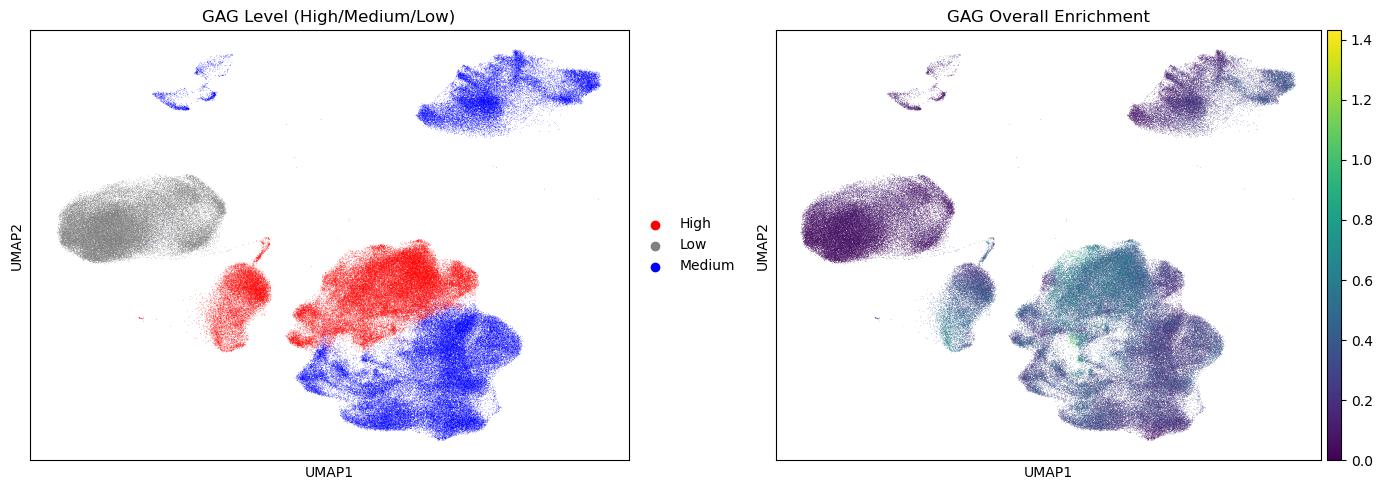

In [20]:
# Identify GAG-high vs GAG-low clusters
# Define high/low based on overall GAG enrichment
cluster_means = {c: overall_gag[clusters == c].mean() for c in unique_clusters}
sorted_clusters = sorted(cluster_means.items(), key=lambda x: x[1], reverse=True)

print("Clusters ranked by overall GAG enrichment:")
print("-" * 60)
for i, (cluster, mean_enrich) in enumerate(sorted_clusters[:10]):
    n_cells = (clusters == cluster).sum()
    print(f"{i+1}. Cluster {cluster}: mean={mean_enrich:.3f}, n_cells={n_cells}")

# Define threshold for high/low (e.g., top and bottom quartiles)
threshold_high = np.percentile(list(cluster_means.values()), 75)
threshold_low = np.percentile(list(cluster_means.values()), 25)

gag_high_clusters = [c for c, m in cluster_means.items() if m >= threshold_high]
gag_low_clusters = [c for c, m in cluster_means.items() if m <= threshold_low]

print(f"\nGAG-high clusters (top quartile, >= {threshold_high:.3f}): {gag_high_clusters}")
print(f"GAG-low clusters (bottom quartile, <= {threshold_low:.3f}): {gag_low_clusters}")

# Create binary classification for visualization
adata.obs['GAG_level'] = 'Medium'
adata.obs.loc[clusters.isin(gag_high_clusters), 'GAG_level'] = 'High'
adata.obs.loc[clusters.isin(gag_low_clusters), 'GAG_level'] = 'Low'

# Plot UMAP colored by GAG level
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
sc.pl.umap(adata, color='GAG_level', ax=axes[0], show=False, 
           title='GAG Level (High/Medium/Low)', palette=['red', 'gray', 'blue'])
sc.pl.umap(adata, color='GAG_overall', ax=axes[1], show=False, 
           title='GAG Overall Enrichment', cmap='viridis')
plt.tight_layout()
plt.show()


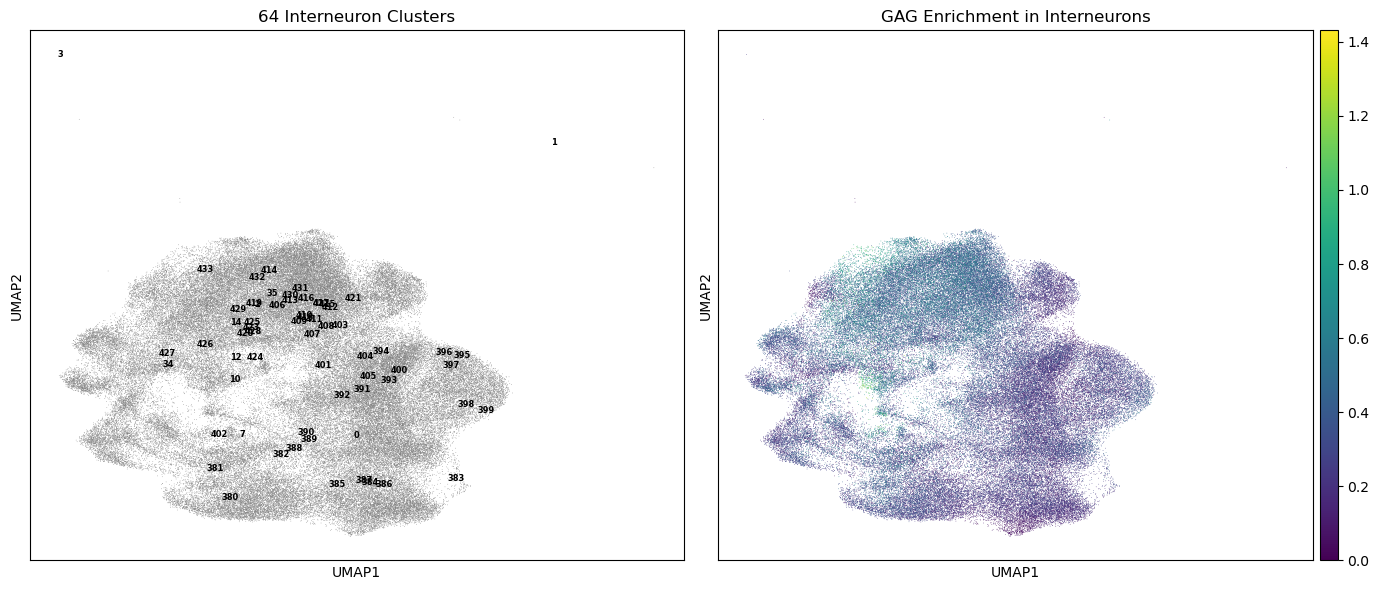


Interneuron cluster size distribution:
count       64.000000
mean      1897.296875
std      10704.423746
min          1.000000
25%          1.000000
50%          1.000000
75%          1.000000
max      67342.000000
Name: count, dtype: float64


In [21]:
# Visualize the 64 interneuron clusters
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Plot 1: Clusters
sc.pl.umap(interneurons, color='leiden', ax=axes[0], 
           show=False, title='64 Interneuron Clusters',
           legend_loc='on data', legend_fontsize=6)

# Plot 2: GAG enrichment
sc.pl.umap(interneurons, color='GAG_overall', ax=axes[1],
           show=False, title='GAG Enrichment in Interneurons',
           cmap='viridis')

plt.tight_layout()
plt.show()

# Print cluster statistics
print(f"\nInterneuron cluster size distribution:")
print(interneurons.obs['leiden'].value_counts().describe())

## Summary

This validation shows:
1. GAG enrichment scores can be computed for each gene set
2. ANOVA tests whether enrichment differs across clusters
3. Visualization reveals GAG-high vs GAG-low patterns

Validation shows: 
1. GAG gene sets are expressed (100% gene coverage)
2. GAG signal is detectable (F-stat = 314)
3. GAG signal is strong within interneurons (not just cell type differences)
4. Current clustering is suboptimal (349 clusters → too many)
5. Filtering to interneurons gives reasonable granularity (64 clusters)

## Phase A Validation Summary

**Validation Results:** The Phase A analysis successfully demonstrates that GAG-sulfation patterns provide a strong biological signal for clustering refinement. All 37 GAG genes are present in the dataset, and ANOVA testing reveals highly significant separation across clusters (F-statistic = 388 for all cells, 314 for interneurons only). When filtering to the 121,427 MGE interneurons—the target population for PNN biology—the GAG signal remains very strong (F=314), confirming that GAG heterogeneity exists within interneuron subtypes, not just between major cell types. The current leiden clustering produces 64 interneuron clusters with clear spatial structure in UMAP and visible GAG enrichment gradients, indicating biologically meaningful heterogeneity. The clustering shows room for optimization: many small clusters exist that could potentially be merged or refined, validating the need for an RL-based approach.

**Next Steps:** Proceed with RL environment development focused on the interneuron-only dataset (121k cells, 64 baseline clusters). Phase B will implement the core reward function components: (1) clustering quality metrics (silhouette score, modularity, cluster balance), (2) GAG separation metrics (ANOVA F-statistics across the 6 gene sets), and (3) penalty functions (for degenerate clusterings with too many/few clusters or singletons). Phase C will implement the five clustering action operations (split worst cluster, merge closest pair, re-cluster at resolution ±0.1, accept). These validated metrics will form the foundation of the Gymnasium environment where the RL agent will learn to balance clustering quality with GAG-sulfation pathway coherence.

In [22]:
interneurons

AnnData object with n_obs × n_vars = 121427 × 32165
    obs: 'Class', 'Region', 'sex', 'development_stage', 'Batch_ID', 'Age', '_scvi_batch', '_scvi_labels', 'doublet', 'singlet', 'leiden', 'GAG_CS_biosynthesis', 'GAG_CS_sulfation', 'GAG_HS_biosynthesis', 'GAG_HS_sulfation', 'GAG_Sulfate_activation', 'GAG_PNN_core', 'GAG_overall'
    var: 'ensembl_id', 'gene_symbol'
    uns: '_scvi_manager_uuid', '_scvi_uuid', 'leiden', 'leiden_colors', 'leiden_sizes', 'neighbors', 'paga', 'umap'
    obsm: 'X_scvi_large', 'X_umap', 'scVI'
    obsp: 'connectivities', 'distances'

In [ ]:
# Save interneurons to processed folder
# First, let's verify the data is valid before saving

print("Verifying interneurons data before saving...")
print(f"  Shape: {interneurons.shape}")
print(f"  X type: {type(interneurons.X)}")
print(f"  X is None: {interneurons.X is None}")

# Check if X is valid
if interneurons.X is not None:
    if hasattr(interneurons.X, 'toarray'):
        print(f"  X sample (sparse): {interneurons.X[0, :5].toarray()}")
    else:
        print(f"  X sample (dense): {interneurons.X[0, :5]}")
else:
    print("  WARNING: X is None!")

print(f"  obsm keys: {list(interneurons.obsm.keys())}")
print(f"  obs columns: {list(interneurons.obs.columns)}")

# Rename X_scvi_large to X_scvi for consistency with our environment code
if 'X_scvi_large' in interneurons.obsm and 'X_scvi' not in interneurons.obsm:
    interneurons.obsm['X_scvi'] = interneurons.obsm['X_scvi_large']
    print("  Added X_scvi (copy of X_scvi_large)")

print("\nData looks valid. Ready to save.")

In [ ]:
# Actually save the file
output_path = './processed/human_interneurons.h5ad'

# Make sure we're saving a proper copy, not a view
if interneurons.is_view:
    print("Converting view to independent AnnData object...")
    interneurons = interneurons.copy()

interneurons.write_h5ad(output_path)
print(f"Saved to: {output_path}")

# Verify the saved file can be loaded
print("\nVerifying saved file...")
test_load = sc.read_h5ad(output_path)
print(f"  Loaded shape: {test_load.shape}")
print(f"  X type: {type(test_load.X)}")
print(f"  obsm keys: {list(test_load.obsm.keys())}")
print("\nSave successful!")